In [94]:
import os
os.sys.path.append("C:\\Users\\amin\\Documents\\Repos\\OpenPNM")

# Summary
One of the main applications of `OpenPNM` is simulating transport phenomena such as Fickian diffusion, advection diffusion, reactive transport, etc. In this example, we will learn how to perform advection diffusion on a `Cubic` network. The algorithm works fine with every other network type, but for now we want to keep it simple. In `OpenPNM`, we've implemented 4 different discretization schemes for the advection diffusion:

1. Upwind
2. Hybrid
3. Powerlaw
4. Exact

Depending on the Peclet regime, the results you get from these schemes might differ. To be on the safe side, either use `Powerlaw` or the `Exact` scheme.

# Problem setup
## Generating network
First, we need to generate a `Cubic` network. For now, we stick to a 2d network, but you might as well try it in 3d!

In [95]:
import openpnm as op
net = op.network.Cubic(shape=[1, 10, 10], spacing=1e-4)

## Adding geometry
Next, we need to add a geometry to the generated network. A geometry contains information about size of the pores/throats in a network. `OpenPNM` has tons of prebuilt geometries that represent the microstructure of different materials such as Toray090 carbon papers, sand stone, electrospun fibers, etc. For now, we stick to a sample geometry called `StickAndBall` that assigns random values to pore/throat diameters.

In [96]:
geom = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)

## Adding phase
Next, we need to add a phase to our simulation. A phase object(s) contain(s) thermophysical information about the working fluid(s) in the simulation. `OpenPNM` has tons of prebuilt phases as well! For this simulation, we use air as our working fluid.

In [97]:
air = op.phases.Air(network=net)

## Adding physics
Finally, we need to add a physics. A physics object contains information about the working fluid in the simulation that depend on the geometry of the network. A good example is diffusive conductance, which not only depends on the thermophysical properties of the working fluid, but also depends on the geometry of pores/throats.

In [98]:
phys_air = op.physics.Standard(network=net, phase=air, geometry=geom)

2018-07-17 13:18:32,991 | WARNING  | root._regen | throat.entry_pressure was not run since the following properties are missing: ['pore.surface_tension', 'throat.diameter']
2018-07-17 13:18:32,997 | WARNING  | root._regen | throat.electrical_conductance was not run since the following properties are missing: ['pore.electrical_conductivity', 'throat.electrical_conductivity', 'throat.equivalent_area', 'throat.conduit_lengths']


# Performing Stokes flow

Note that the advection diffusion algorithm assumes that velocity field is given. Naturally, we solve Stokes flow inside a pore network model to obtain the pressure field, and eventually the velocity field. Therefore, we need to run the `StokesFlow` algorithm prior to running our advection diffusion. There's a separate tutorial on how to run `StokesFlow` in `OpenPNM`, but here's a simple code snippet that does the job for us.

In [99]:
sf = op.algorithms.StokesFlow(network=net, phase=air)
sf.set_value_BC(pores=net.pores('left'), values=200.0)
sf.set_value_BC(pores=net.pores('right'), values=0.0)
sf.run();

It is essential that you attach the results from `StokesFlow` (i.e. pressure field) to the corresponding phase, since the results from any algorithm in `OpenPNM` are by default only attached to the algorithm object (in this case to `sf`). Here's how you can update your phase:

In [100]:
air.update(sf.results())

# Performing advection diffusion

Now that everything's set up, it's time to perform our advection diffusion simulation. For this purpose, we need to add corresponding algorithm to our simulation. As mentioned above, `OpenPNM` supports 4 different discretizations, 3 of which are encapsulated in `AdvectionDiffusion` and the one based on the exact solution is located in `Dispersion`. First let's use `AdvectionDiffusion`:

In [101]:
ad = op.algorithms.AdvectionDiffusion(network=net, phase=air)

Note that `network` and `phase` are required parameters for pretty much every algorithm we add, since we need to specify on which network and for which phase do we want to run the algorithm.

So far, we haven't mentioned how you specify the discretization. You can specify the discretization by modifying the `settings` of our `AdvectionDiffusion` algorithm. You can choose between `upwind`, `hybrid` and `powerlaw`.

In [102]:
ad.settings.update({'s_scheme': 'powerlaw'})

## Adding boundary conditions
Next, we need to add some boundary conditions to the simulation. By default, `OpenPNM` assumes zero flux for the boundary pores.

In [103]:
inlet  = net.pores('left') 
outlet = net.pores(['right', 'top', 'bottom'])
ad.set_value_BC(pores=inlet, values=100.0)
ad.set_value_BC(pores=outlet, values=0.0)

`set_value_BC` applies the so-called "Dirichlet" boundary condition to the specified pores. Note that unless you want to apply a single value to all of the specified pores (like we just did), you must pass a list (or `ndarray`) as the `values` parameter.

## Running the algorithm
Now, it's time to run the algorithm. This is done by calling the `run` method attached to the algorithm object.

In [104]:
ad.run();

# Post processing
When an algorithm is successfully run, the results are attached to the same object. To access the results, you need to know the quantity for which the algorithm was solving. For instance, `AdvectionDiffusion` solves for the quantity `pore.concentration`, which is somewhat intuitive. However, if you ever forget it, or wanted to manually check the quantity, you can take a look at the algorithm `settings`:

In [105]:
print(ad.settings)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
key                                 value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
sources                             []
tolerance                           0.001
max_iter                            10000
relaxation_source                   1
relaxation_quantity                 1
phase                               phase_01
conductance                         None
quantity                            pore.concentration
solver                              spsolve
prefix                              alg
diffusive_conductance               throat.diffusive_conductance
hydraulic_conductance               throat.hydraulic_conductance
pressure                            pore.pressure
s_scheme                            powerlaw
t_scheme                            None
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now that we know the quantity for which `AdvectionDiffusion` was solved, let's take a look at the results:

In [106]:
c = ad['pore.concentration']
print(c)

[   0.          100.          100.          100.          100.          100.
  100.          100.          100.            0.            0.
   75.60903407   86.22770115   91.78076354   91.85887006   88.72189804
   84.28664691   76.243215     49.81288882    0.            0.
   49.93724776   71.58487195   79.24519222   81.21469925   75.28152362
   70.24355943   52.78642171   29.05090553    0.            0.
   35.71510144   58.73879491   70.82759935   70.17372738   67.97609028
   66.16467219   47.47483591   21.28520441    0.            0.
   26.74522249   47.96679971   58.48653128   60.05368185   60.55898361
   60.14398877   40.21124687   16.33190727    0.            0.
   26.68065899   39.90793243   44.37476322   50.89989389   53.27428608
   48.90901683   35.92037381   16.5143695     0.            0.
   28.07640055   35.75609338   39.48716212   41.71278582   43.91368767
   39.68583386   29.08888445   13.76877114    0.            0.
   17.18332058   31.62501908   34.72762733   33.04166734

## Heatmap
Well, it's hard to make sense out of a bunch of numbers! Let's visualize the results. Since the network is 2d, we can simply reshape the results in form of a 2d array similar to the shape of the network and plot the heatmap of it using `matplotlib`.

In [107]:
print('Network shape:', net._shape)
c2d = c.reshape((net._shape))

Network shape: (1, 10, 10)


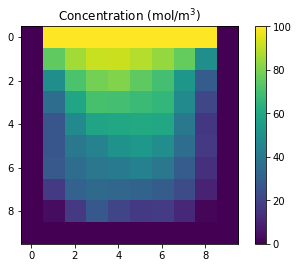

In [108]:
import matplotlib.pyplot as plt
plt.imshow(c2d[0,:,:])
plt.title('Concentration (mol/m$^3$)')
plt.colorbar()